In [1]:
using Pkg
Pkg.activate("..")

 Activating environment at `~/Documents/Catlab/AlgebraicDynamics.jl/Project.toml`


In [ ]:
using AlgebraicDynamics

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.CategoricalAlgebra.CSets
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Catlab.Graphs
using Catlab.Graphs.BasicGraphs: TheoryGraph, Graph
using Catlab.Theories: id

using DifferentialEquations

using Plots

import Catlab.CategoricalAlgebra: subpart

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1260


In [ ]:
# Data migration code

function migrate!(Y::ACSet{CD, AD}, X::ACSet, FOb::Dict, FHom::Dict) where {CD, AD}
  CD.ob ⊆ keys(FOb)     || error("Every object in $CD must be a key in $FOb")
  CD.hom ⊆ keys(FHom)   || error("Every hom in $CD must be a key in $FHom")
  AD.attr ⊆ keys(FHom)  || error("Every attribute in $AD must be a key in $FHom")
  
  for (obY, obX) in FOb  
    add_parts!(Y, obY, nparts(X, obX))
  end

  for (homY, homX) in FHom
    set_subpart!(Y, homY, subpart(X, homX))
  end
  return Y
end

function (::Type{T})(X::ACSet, FOb::Dict, FHom::Dict) where T <: AbstractACSet
  Y = T(); migrate!(Y, X, FOb, FHom)
end


subpart(acs::ACSet, expr::GATExpr{:id}) = parts(acs, first(dom(expr)))

# Implementing Resources Sharing Machines

In this notebook, we describe the process of composing dynamical systems as (1) resource sharers, (2) machines, and (3) resource sharing machines.

These features are implemented more complicated-ly in the AlgebraicDynamics.jl package. In this notebook we implement "baby" versions for the sake of clarity.

## A Theory of Machines

We define a machine to be a system which takes input, updates its internal state, and exposes some output. The schema for machines is:

<img src="images/Theory of Machines.png" alt="schema for theory of machines" style="width: 600px;"/>

Note that this composition pattern is a special case of an operation in the operad of wiring diagrams of finite sets where the codomain is the unit.

In [ ]:
@present TheoryMachines(FreeSchema) begin        
    Dynamics::Data

    Box::Ob
    InPort::Ob
    OutPort::Ob
    StateVariable::Ob

    parameterizes::Hom(InPort, Box)
    state::Hom(OutPort, StateVariable)
    system::Hom(StateVariable, Box)
    feeder::Hom(InPort, OutPort)
    
    dynamics::Attr(Box, Dynamics)
end

const AbstractMachine = AbstractACSetType(TheoryMachines)
const Machine = ACSetType(TheoryMachines, index=[:parameterizes, :state, :system, :feeder, :dynamics])
Machine() = Machine{Function}()

In [ ]:
# Turn a Machine into an ODE problem

function get_dynamics(m::AbstractMachine)
    function dynamics!(newstate, u)
        for b in parts(m, :Box)
            ivalues = view(u,  subpart(m, subpart(m, incident(m, b, :parameterizes),  :feeder), :state))
            states = incident(m, b, :system)
            dynamics = subpart(m, b, :dynamics)
            view(newstate, states) .= dynamics(view(u, states), ivalues)
        end
        newstate
    end
end

function vectorfield(m::AbstractMachine)
    update! = get_update(m)
    function f(u, p, t)
        return update!(zero(u),u)
    end
end

## Lokta-Volterra as machines

A parameterized ODE modeling a rabbit population takes as input a population of predators $\mathsf{pred}$ and evolves according to $$\dot r(\mathsf{pred})\alpha r - \beta r(\mathsf{pred})$$.

Similarly a ODE modeling a fox population takes as input a population of prey $\mathsf{prey}$ and evolves according to $$\dot f(\mathsf{prey}) = -\gamma f + \delta  f(\mathsf{prey}).$$

In [ ]:
# parameters and initial condition chosen to match the example in 
#      https://algebraicjulia.github.io/AlgebraicPetri.jl/dev/examples/predation/lotka-volterra/
α = .3
β = .015
γ = .7
δ = β

u0 = [10.0, 100.0]

dotr = (r,pred) -> [α*r[1] - β*r[1]*pred[1]]
dotf = (f,prey) -> [δ*f[1]*prey[1] - γ*f[1]]

lv = Machine()
add_parts!(lv, :Box,    2, dynamics = [dotr, dotf])
add_parts!(lv, :StateVariable,  2, system = [1,2])
add_parts!(lv, :OutPort,2, state = [1,2])
add_parts!(lv, :InPort, 2, parameterizes = [1,2], feeder = [2,1])

lv

In [ ]:
prob = ODEProblem(vectorfield(lv), u0, (0.0, 100.0))
sol = solve(prob)
plot(sol)

## Modularity of Machines

One of the great things about compositional dynamics is that you can build your models modularly.

For example consider an ecosystem composed of little fish, big fish, and sharks where the big fish are predators to the little fish and prey to the sharks. To construct the ODE corresponding to this model, you might get lost trying to keep all of your variables straight. However, as a composition of machines, it is much more straightforward.

In [ ]:
α = .3
β = .015
γ = .7
δ = β
β′ = .017
γ′ = .35
δ′ = β′

u0 = [100.0, 10.0, 2.0]

dotfish(f, x) = [α*f[1] - β*x[1]*f[1]]
dotFISH(F, x) = [δ*x[1]*F[1] - γ*F[1] - β′*x[2]*F[1]]    # x[1] - prey, x[2] - predator
dotsharks(s, x) = [-γ′*s[1] + δ′*s[1]*x[1]]

lv3 = Machine()
add_parts!(lv3, :Box,    3, dynamics = [dotfish, dotFISH, dotsharks])
add_parts!(lv3, :StateVariable,  3, system = [1,2,3])
add_parts!(lv3, :OutPort,3, state = [1,2,3])
add_parts!(lv3, :InPort, 4, parameterizes = [1,2,2,3], feeder = [2,1,3,2])

lv3

In [ ]:
prob = ODEProblem(vectorfield(lv3), u0, (0.0, 100.0))
sol = solve(prob)
plot(sol)

## Machines from Graphs

We can further improve upon the modularity of machines by building machines out of graphs where each vertex is equipped with a vector field. We want to assume that the dynamics to vertex $v$ has $n$ parameters where $n$ is the number of edges incoming to $v$. The ordering of the parameters is induced by the ordering of the edges.

In [ ]:
@present TheoryLabeledGraph <: TheoryGraph begin
    Label::Data
    label::Attr(V, Label)
end

const AbstractLabeledGraph = AbstractACSetType(TheoryLabeledGraph)
const LabeledGraph = ACSetType(TheoryLabeledGraph, index=[:src, :tgt, :label])
DynamGraph() = LabeledGraph{Function}()

In [ ]:
V = TheoryLabeledGraph[:V]
E = TheoryLabeledGraph[:E]

Machine(g::LabeledGraph) = Machine(g, 
   Dict(:InPort => :E, :OutPort => :E, :Box => :V, :StateVariable => :V),
   Dict(:parameterizes => :src, :feeder => id(E), :state => :tgt, :system => id(V), :dynamics => :label)
)

In [ ]:
lv3_graph = DynamGraph()
add_parts!(lv3_graph, :V, 3, label=[dotfish, dotFISH, dotsharks])
add_parts!(lv3_graph, :E, 4, src=[1,2,2,3], tgt=[2,1,3,2])

lv3_graph

In [ ]:
lv3′ = Machine(lv3_graph)

In [ ]:
prob = ODEProblem(vectorfield(lv3′), u0, (0.0, 100.0))
sol = solve(prob)
plot(sol)

This migration from dynamics equipped graphs to machines makes things like cellular automata easy to code up!

In [ ]:
n = 20
rule_number = 30

function rule(n)
    function rule(c,l,r)
        R = digits(n, base=2, pad = 8)
        d = [l,c,r]
        i = sum([d[k]*2^(k-1) for k=1:length(d)])
        return R[i]
    end
end

function dynamics(x, nbs)
    R = rule(rule_number)
    if length(nbs)==2
        return R(nbs[1], x, nbs[2])
    end
    return 1 # boundary condition
end

g = DynamGraph()

add_parts!(g, :V, n, label=fill(dynamics, n))

add_parts!(g, :E, n-1, src=1:(n-1), tgt=2:n)
add_parts!(g, :E, n-1, src=2:n, tgt =1:(n-1))

In [ ]:
N = 100

update! = get_update(Machine(g))

u0 = zeros(n)
u0[floor(Int, n/2)] = 1

xs = Array{Int64}(undef, N + 1, n)
xs[1, : ] = u0

for i in 1:N
    update!(view(xs,i+1, 1:n), view(xs, i, 1:n))
end

In [ ]:
function rule(n)
    function rule(c,r,l)
        R = digits(n, base=2, pad = 8)
        d = [l,c,r]
        i = sum([d[k]*2^(k-1) for k=1:length(d)])
        return R[i]
    end
end

In [ ]:
R = rule(3)
R(1,1,0)

# Resource Sharers

Machines are all about directed communication --- one machine sends informationa about its states to another machine

## Appendix

In [184]:
# Discrete update function

function update!(y::AbstractVector, f::Function, x::AbstractVector, args...)
    y .= f(x, args...)
end

function update!(newstate::AbstractVector, dm::AbstractMachine, state::AbstractVector) 
    
    for b in parts(dm, :Box)
        ivalues = view(state,  subpart(dm, incident(dm, b, :parameterizes), :feeder))
        states = incident(dm, b, :system)
        dynamics = subpart(dm, b, :dynamics)
        newvalues = update!(view(newstate, states),
                            dynamics, 
                            view(state, states), 
                            ivalues)
    end
    
    return newstate
end

update! (generic function with 4 methods)

In [ ]:
α = 1.2
β = 0.1
γ = 1.3
δ = 0.1

dotr = (r,i) -> [α*r[1] - β*i[1]*r[1]]
dotf = (f,j) -> [-γ*f[1] + δ* j[1]* f[1]]

function eulers(f::Function, h::Float64) 
    return (x0, args...) -> x0 .+ h*f(x0, args...)
end

function approx(f::Function, h::Float64)
    return (x0, args...) -> solve(ODEProblem((x,p,t) -> f(x0, args...), x0, (0, h)), 
                                    save_everystep = false, save_start=false,save_end = true)[1]
end

h = 0.1

lv = Machine()
add_parts!(lv, :Box,    2, dynamics = [eulers(dotr,h), eulers(dotf,h)])
add_parts!(lv, :StateVariable,  2, system = [1,2], value=[17, 11])
add_parts!(lv, :OutPort,2, state = [1,2])
add_parts!(lv, :InPort, 2, parameterizes = [1,2], feeder = [2,1])

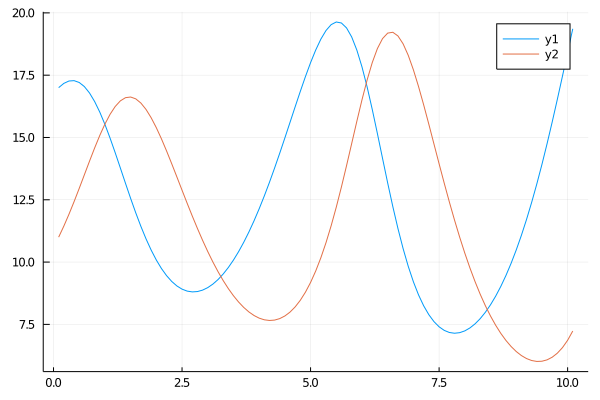

In [198]:
N = 100
k = nparts(lv, :StateVariable)

xs = Array{Float64}(undef, N + 1, k)
xs[1, : ] = subpart(lv, :value)

for i in 1:N
    update!(view(xs,i+1, 1:k), lv, view(xs, i, 1:k))
end

ts = map(t -> t*h, 1:N+1)
rs = xs[:, 1]
fs = xs[:, 2]

plot(ts, rs)
plot!(ts, fs)